Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy import stats
import statistics
import pingouin as pg
from scipy.stats import friedmanchisquare
import plotly.graph_objects as go
import plotly.express as px


/home/friction_15/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/friction_15/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [30]:
# Set the path to the logfile directory
filepath = "/"
# Get a list of filenames in the specified directory
filepaths = os.listdir(filepath)

# Define the range of trials
trials = range(0, 200)

# Define the desired order of file processing
order = [1, 2, 0]
filepaths = [filepaths[i] for i in order]

# Specify any outliers to be excluded from analysis
# Commented out for now
# outlier = []
outlier = ['']

# Initialize empty lists and dictionaries
rt_all = []
accuracy_all = []
hit_length = {k:[] for k in filepaths}
acc_dict = {k:[] for k in filepaths}
dprime_dict = dict()
hit_rate_dict = dict()
fa_rate_dict = dict()
timeDurationDf = pd.DataFrame()

# Iterate through each file in the filepaths list
for file in filepaths:
    # Get the list of files within the specific file's directory
    files = os.listdir(filepath + file + "/")

    # Initialize a DataFrame for the subject's data
    sub_df = pd.DataFrame(index=trials)

    # Initialize lists to store specific condition data
    rt_cond = []
    subject_name = []
    accuracy_cond = []
    timeDuration = []

    # Exclude outliers from the files list
    files_except_outliers = [i for i in files if i[:10] not in outlier]

    # Initialize DataFrames to store dprime, false alarm rate, and hit rate for each subject
    dprime_df = pd.DataFrame(index=['dprime'])
    fa_rate_df = pd.DataFrame(index=['falserate'])
    hit_rate_df = pd.DataFrame(index=['hitrate'])

    # Iterate through each file (excluding outliers) in the current file's directory
    for i in files_except_outliers:
        # Generate the filename for the current subject
        filename = "sub_" + i[8:10]

        # Read the data from the file into a DataFrame
        df = pd.read_csv(filepath + file + '/' + i, skiprows=3, delimiter="\t")
        
        # Data cleaning and manipulation steps
        df1 = df.drop(df.dropna(subset=['Time']).index).reset_index()
        df1.dropna(axis=1, how='all', inplace=True)
        df1.columns = df1.iloc[0]
        df1.drop(index=0, inplace=True)
        df2 = df1.drop(df1.iloc[:, [0, 1]], axis=1)
        df2["RT"] = df2["RT"].astype(float) / 10
        df2 = df2[df2["Code"].str.len() > 5]
        df2[["TRIAL TYPE", "BLOCK", "STIM", "BACK", "TRIAL NUMBER", "STIM NAME", "STIM IDX", "tCOND", "tRESP"]] = df2["Code"].str.split(';', expand=True)
        df2 = df2.drop(df2.iloc[:, [0]], axis=1)
        df2["BLOCK"] = df2["BLOCK"].astype(float)
        df2 = df2[df2['BLOCK'] == 1]

        
        cols = ["BLOCK", "TRIAL NUMBER", "tCOND", "tRESP"]
        for col in cols:
            temp = df2[col]
            df2.drop(labels=[col], axis=1, inplace=True)
            df2.insert(1, col, temp)

        time = df2["Time"].tolist()
        timeDuration.append(int(time[-1]) / 60 / 10000)

        # Reaction time (RT) calculations
        df_rt = df2[df2["tRESP"] == "Hit"]
        df_miss = df2[df2['tRESP'] == "Miss"]
        df_CR = df2[df2['tRESP'] == "Correct Rejection"]
        df_fa = df2[df2['tRESP'] == "False Alarm"]
        rt_cond.append(df_rt["RT"].mean())

        if np.isnan(df_rt["RT"].mean()):
            print(filename)

        subject_name.append(filename)

        # Accuracy calculations
        accuracy_cond.append((len(df_rt) + len(df_CR)) / 200 * 100)

        # Store hit length for the current file
        hit_length[file].append(len(df_rt))

        # Store accuracy values for the current file
        acc_dict[file] = accuracy_cond

        # Calculate hit rate and false alarm rate
        hit_rate = len(df_rt) / (len(df_rt) + len(df_miss))
        fa_rate = round(len(df_fa) / (len(df_fa) + len(df_CR)), 6)

        # Adjust extreme hit rate and false alarm rate values
        if hit_rate == 1:
            hit_rate = 0.99
        if hit_rate == 0:
            hit_rate = 0.01
        if fa_rate == 1:
            fa_rate = 0.9967
        if fa_rate == 0:
            fa_rate = 0.0033

        # Calculate d' (d prime) value
        dprime_df[filename] = stats.norm.ppf(hit_rate) - stats.norm.ppf(fa_rate)
        fa_rate_df[filename] = fa_rate
        hit_rate_df[filename] = hit_rate

        # Normality tests (Shapiro-Wilk test)
        # Commented out for now
        # n,p = shapiro(df_rt["RT"])
        # if p > 0.05:
        #     print(filename, n, p)

    # Store hit rate, false alarm rate, and d' (d prime) values for the current file
    hit_rate_dict[file] = hit_rate_df
    fa_rate_dict[file] = fa_rate_df
    rt_all.append(rt_cond)
    accuracy_all.append(accuracy_cond)
    timeDurationDf[file] = timeDuration


/tmp/ipykernel_13629/4003031366.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["RT"] = df2["RT"].astype(float) / 10


creating data frames

In [31]:
# Create a DataFrame for reaction time (RT) data
dataRt = pd.DataFrame(index=subject_name)
for ind, i in enumerate(filepaths):
    dataRt[i] = rt_all[ind]
dataRt.sort_index(inplace=True)

# Create a dictionary to store d' (d prime) values
dprime_dictt = dict()
for key in fa_rate_dict.keys():
    dprime_dictt[key] = pd.DataFrame({'d_prime': (stats.norm.ppf(hit_rate_dict[key]) - stats.norm.ppf(fa_rate_dict[key]))[0]},
                                     index=fa_rate_df.T.index)

# Total hits across conditions
hit_conds = pd.DataFrame()
hit_conds['Sham'] = hit_length['Sham']
hit_conds['Fixed dose'] = hit_length['Fixed dose']
hit_conds['Individualised dose'] = hit_length['Individualised dose']

In [32]:
# Total stimulation duration (minutes)
for i, row in timeDurationDf.T.iterrows():
    print(i + " MEAN: " + str(row.mean()))
    print(i + " SD: " + str(row.std()))
    print(i + " MIN: " + str(row.min()))
    print(i + " MAX: " + str(row.max()))
    print("")

Sham MEAN: 7.920449761904761
Sham SD: 0.9901866654484326
Sham MIN: 6.834925
Sham MAX: 12.611841666666667

Fixed dose MEAN: 7.817544000000002
Fixed dose SD: 0.8356580457918187
Fixed dose MIN: 6.648283333333333
Fixed dose MAX: 10.307738333333333

Individualised dose MEAN: 7.894285142857143
Individualised dose SD: 0.8142409110284136
Individualised dose MIN: 6.42042
Individualised dose MAX: 10.649965



In [33]:
# Print mean, standard deviation, and variance of hit counts
for column in hit_conds.columns:
    print(column)
    print('Mean:', round(hit_conds[column].mean(), 3))
    print('Standard Deviation:', round(hit_conds[column].std(), 2))
    print('Variance:', round(hit_conds[column].var(), 2))
    print('')


Sham
Mean: 38.714
Standard Deviation: 7.54
Variance: 56.86

Fixed dose
Mean: 39.543
Standard Deviation: 8.4
Variance: 70.49

Individualised dose
Mean: 38.8
Standard Deviation: 7.53
Variance: 56.64



In [34]:
# Print mean accuracy across conditions
for key in acc_dict:
    print(f"{key}\nMean: {round(statistics.mean(acc_dict[key]), 3)}")
    print(f"SD {round(statistics.stdev(acc_dict[key]), 3)}")
    print(f"Variance: {round(statistics.variance(acc_dict[key]),2)}")
    print("")

Sham
Mean: 90.243
SD 5.407
Variance: 29.24

Fixed dose
Mean: 90.757
SD 6.445
Variance: 41.53

Individualised dose
Mean: 90.129
SD 5.625
Variance: 31.64



In [35]:
# Print mean, standard deviation, and variance of d' (d prime) values
for key in dprime_dictt:
    print(key)
    print(f"Mean: {round(dprime_dictt[key].mean(),3)}")
    print(f"SD: {round(dprime_dictt[key].std(),2)}")
    print(f"Variance: {round(dprime_dictt[key].var(),2)}")
    print("")

Sham
Mean: d_prime    2.569
dtype: float64
SD: d_prime    0.73
dtype: float64
Variance: d_prime    0.53
dtype: float64

Fixed dose
Mean: d_prime    2.716
dtype: float64
SD: d_prime    0.94
dtype: float64
Variance: d_prime    0.88
dtype: float64

Individualised dose
Mean: d_prime    2.599
dtype: float64
SD: d_prime    0.82
dtype: float64
Variance: d_prime    0.67
dtype: float64



In [36]:
# Print mean, standard deviation, and variance of RT(ms) values
for key in dataRt.columns:
    print(key)
    print(f"Mean: {round(dataRt[key].mean(),3)}")
    print(f"SD: {round(dataRt[key].std(),2)}")
    print(f"Variance: {round(dataRt[key].var(),2)}")
    print("")

Sham
Mean: 716.264
SD: 166.59
Variance: 27753.3

Fixed dose
Mean: 698.118
SD: 155.58
Variance: 24205.43

Individualised dose
Mean: 718.811
SD: 144.89
Variance: 20991.92



Ploting distribution of hits across conditions

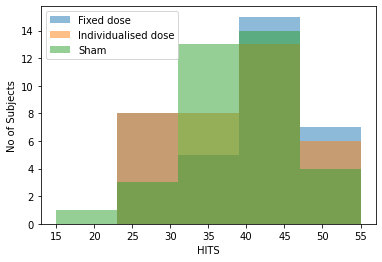

In [37]:
# Plot histograms of hit counts
plt.hist(hit_length["Fixed dose"], bins=5, range=(15, 55), alpha=0.5, label="Fixed dose")
plt.hist(hit_length["Individualised dose"], bins=5, range=(15, 55), alpha=0.5, label="Individualised dose")
plt.hist(hit_length["Sham"], bins=5, range=(15, 55), alpha=0.5, label="Sham")
plt.xlabel("HITS")
plt.ylabel("No of Subjects")
plt.legend()
plt.show()

normality- condition wise

In [38]:
# Shapiro-Wilk normality test and Levene's test for accuracy, RT, and d' data
for data_type, data_dict in [("Accuracy", acc_dict), ("Reaction Time (RT)", dataRt), ("d' (d prime)", dprime_dictt)]:
    print(f"\n--- {data_type} ---")
    
    # Shapiro-Wilk normality test
    print("Shapiro-Wilk normality test:")
    for key, data in data_dict.items():
        test, p = shapiro(data)
        print(f"{key}: Test statistic={test}, p-value={p}")


--- Accuracy ---
Shapiro-Wilk normality test:
Sham: Test statistic=0.913947343826294, p-value=0.00957991648465395
Fixed dose: Test statistic=0.9143509268760681, p-value=0.009834753349423409
Individualised dose: Test statistic=0.9510295391082764, p-value=0.12188240140676498

--- Reaction Time (RT) ---
Shapiro-Wilk normality test:
Sham: Test statistic=0.9280670881271362, p-value=0.02451764978468418
Fixed dose: Test statistic=0.9664640426635742, p-value=0.3537101745605469
Individualised dose: Test statistic=0.9304971694946289, p-value=0.028943926095962524

--- d' (d prime) ---
Shapiro-Wilk normality test:
Sham: Test statistic=0.981633722782135, p-value=0.8109832406044006
Fixed dose: Test statistic=0.9593436121940613, p-value=0.21850988268852234
Individualised dose: Test statistic=0.9811519384384155, p-value=0.7960168719291687


In [39]:
# Perform Levene's test for equality of variances on accuracy data
print("Levene's test for accuracy:")
l_acc, p_acc = levene(*accuracy_all)
print(f"Test statistic={l_acc}, p-value={p_acc}")

# Perform Levene's test for equality of variances on RT data
print("Levene's test for reaction time (RT):")
l_rt, p_rt = levene(*rt_all)
print(f"Test statistic={l_rt}, p-value={p_rt}")
# Perform Levene's test for equality of variances on d' (d prime) data
print("Levene's test for d'prime")
l, pp = levene(dprime_dictt["Fixed dose"]["d_prime"].to_numpy(), dprime_dictt["Individualised dose"]["d_prime"].to_numpy(),
               dprime_dictt["Sham"]["d_prime"].to_numpy())
print(l, pp)

Levene's test for accuracy:
Test statistic=0.36215996751928603, p-value=0.6970625419914223
Levene's test for reaction time (RT):
Test statistic=0.31584228513832774, p-value=0.7298849931401192
Levene's test for d'prime
0.9475318308715849 0.3910823082461661


one way anova   

In [41]:
# Friedman test (ANOVA) on RT data
friedman_rt = pg.friedman(dataRt, method='chisq')
print("RT - Friedman test (ANOVA):")
print(friedman_rt)

# Friedman test (ANOVA) on accuracy data
acc_df = pd.DataFrame({
    "Sham": acc_dict["Sham"],
    "Fixed dose": acc_dict["Fixed dose"],
    "Individualised dose": acc_dict["Individualised dose"]
})
friedman_acc = pg.friedman(acc_df, method='chisq')
print("Accuracy - Friedman test (ANOVA):")
print(friedman_acc)

# Friedman test (ANOVA) on d' (d prime) data
dprime_df_cond = pd.DataFrame({
    "Sham": dprime_dictt['Sham']['d_prime'],
    "Fixed dose": dprime_dictt['Fixed dose']['d_prime'],
    "Individualised dose": dprime_dictt['Individualised dose']['d_prime']
})
friedman_dprime = pg.friedman(dprime_df_cond, method="chisq")
print("d' (d prime) - Friedman test (ANOVA):")
print(friedman_dprime)

RT - Friedman test (ANOVA):
          Source         W  ddof1    Q     p-unc
Friedman  Within  0.005714      2  0.4  0.818731
Accuracy - Friedman test (ANOVA):
          Source         W  ddof1         Q     p-unc
Friedman  Within  0.013251      2  0.927536  0.628909
d' (d prime) - Friedman test (ANOVA):
          Source         W  ddof1    Q     p-unc
Friedman  Within  0.017143      2  1.2  0.548812
 


Violin plots

defining functions

In [42]:
# Define function to calculate lower and upper adjacent values based on quartiles
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Define function to set axis style
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, fontsize=18, fontname="sans")
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

rt across cond

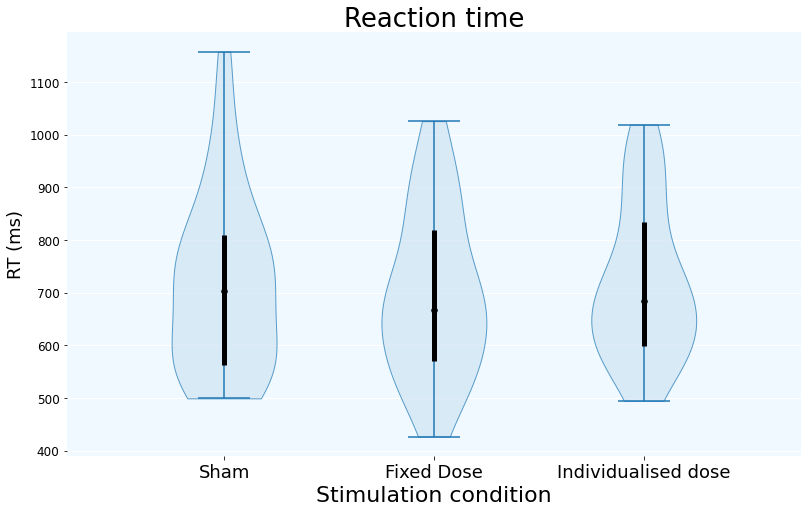

In [44]:
# Prepare the data to plot
data_to_plot = [dataRt['Sham'], dataRt['Fixed dose'], dataRt['Individualised dose']]

# Create the figure and axes
fig = plt.figure(figsize=(12, 7))
ax = fig.add_axes([0.09, 0.1, 0.85, 0.84])

# Configure axis and plot style
ax.tick_params(axis='y', which='major', labelsize=12)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.grid(True, axis="y", color='w', linestyle='-', linewidth=1.2, which="major", zorder=-1.0)
ax.patch.set_facecolor('#f0f9ff')
plt.rc("axes", axisbelow=True)

# Create the violin plot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
label = ['Sham', 'Fixed Dose', 'Individualised dose']

# Set axis style
for ax in [ax]:
    set_axis_style(ax, label)

# Set plot labels and title
ax.set_xlabel('Stimulation condition', fontsize=22, fontname="sans-serif")
ax.set_ylabel('RT (ms)', fontsize=18, fontname="sans-serif")
ax.set_title('Reaction time', fontsize=26, fontname="sans-serif")

# Customize violin plot appearance
for pc in bp['bodies']:
    pc.set_facecolor('#cfe5f3')
    pc.set_edgecolor('#1d78b6')
    pc.set_alpha(0.7)

# Calculate quartiles, whiskers, and medians
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

# Plot medians, quartiles, and whiskers
inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='black', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='black', linestyle='-', lw=4)

# Uncomment the following line if you want to save the plot as an image file
# plt.savefig(".jpg", format="jpg", dpi=500)


Accuracy

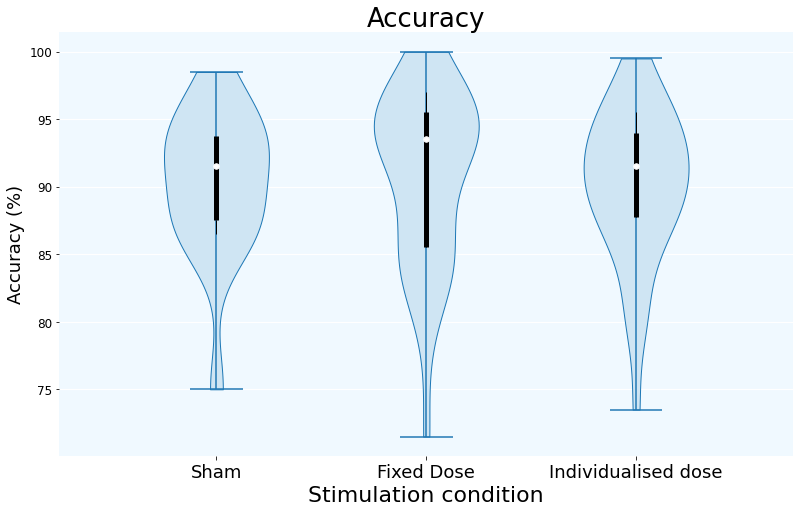

In [45]:
data_to_plot = [acc_dict['Sham'], acc_dict['Fixed dose'], acc_dict['Individualised dose']]
fig = plt.figure(figsize=(12, 7))

# Create an axes instance
ax = fig.add_axes([0.09, 0.1, 0.85, 0.84])
ax.tick_params(axis='y', which='major', labelsize=12)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.grid(True, axis="y", color='w', linestyle='-', linewidth=1.2, which="major", zorder=-1.0)
ax.patch.set_facecolor('#f0f9ff')
plt.rc("axes", axisbelow=True)

# Create the violin plot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Sham', 'Fixed Dose', 'Individualised dose']

# Set axis style
for ax in [ax]:
    set_axis_style(ax, labels)

# Set plot labels and title
ax.set_xlabel('Stimulation condition', fontsize=22, fontname="sans-serif")
ax.set_ylabel('Accuracy (%)', fontsize=18, fontname="sans-serif")
ax.set_title('Accuracy', fontsize=26, fontname="sans-serif")

# Customize violin plot appearance
for pc in bp['bodies']:
    pc.set_facecolor('#cfe5f3')
    pc.set_edgecolor('#1d78b6')
    pc.set_alpha(1)

# Calculate quartiles, whiskers, and medians
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

# Plot medians, quartiles, and whiskers
inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Uncomment the following line if you want to save the plot as an image file
# plt.savefig(".jpg", format="jpg", dpi=500)


dprime

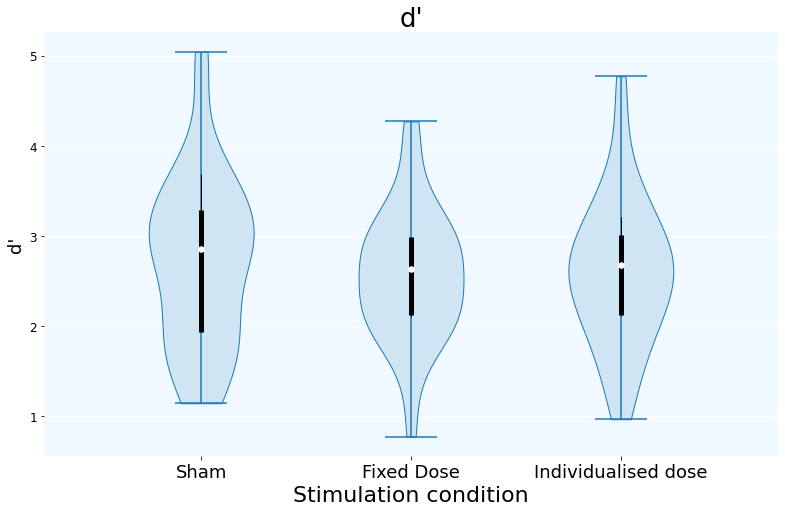

In [46]:
fix_dprime = dprime_dictt['Sham']['d_prime'].to_numpy()
sham_dprime = dprime_dictt['Fixed dose']['d_prime'].to_numpy()
ind_dprime = dprime_dictt['Individualised dose']['d_prime'].to_numpy()

data_to_plot = [sham_dprime, fix_dprime, ind_dprime]
fig = plt.figure(figsize=(12, 7))

# Create an axes instance
ax = fig.add_axes([0.09, 0.1, 0.85, 0.84])
ax.tick_params(axis='y', which='major', labelsize=12)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.grid(True, axis="y", color='w', linestyle='-', linewidth=1.2, which="major", zorder=-1.0)
ax.patch.set_facecolor('#f0f9ff')
plt.rc("axes", axisbelow=True)

# Create the violin plot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Sham', 'Fixed Dose', 'Individualised dose']

# Set axis style
for ax in [ax]:
    set_axis_style(ax, labels)

ax.set_xlabel('Stimulation condition', fontsize=22, fontname="sans-serif")
ax.set_ylabel("d'", fontsize=18, fontname="sans-serif")
ax.set_title("d'", fontsize=26, fontname="sans-serif")

# Customize violin plot appearance
for pc in bp['bodies']:
    pc.set_facecolor('#cfe5f3')
    pc.set_edgecolor('#1d78b6')
    pc.set_alpha(1)

# Calculate quartiles, whiskers, and medians
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Uncomment the following line if you want to save the plot as an image file
# plt.savefig("/dPrime_sham.jpg", format="jpg", dpi=500)


In [47]:
acc_fix = acc_dict["Fixed dose"]
acc_ind = acc_dict["Individualised dose"]

rt_fix = dataRt["Fixed dose"].to_list()
rt_ind = dataRt["Individualised dose"].to_list()

cond1 = ["Fixed"]*(len(acc_fix) + len(rt_fix))
cond2 = ["Individualised"]*(len(acc_ind) + len(rt_ind))



roi1 = ["Accuracy"]*len(acc_fix)
roi2 = ["RT"]*len(rt_fix)
roi3 = ["Accuracy"]*len(acc_ind)
roi4 = ["RT"]*len(rt_ind)

df_plot = pd.DataFrame({"data": acc_fix + rt_fix + acc_ind +  rt_ind, "cond" : cond1 + cond2, "ROI": roi1 + roi2 + roi3 + roi4})

In [53]:
show_legend = [True,True,False,False]

for ii in range(2):
    fig = go.Figure()
    i = ii # For accuracy::if ii = 0 ; RT:: ii = 1 for accuracy
    fig.add_trace(go.Violin(x=df_plot['ROI'][(df_plot['cond'] == 'Fixed') &
                                    (df_plot['ROI'] == pd.unique(df_plot['ROI'])[i])],
                        y=df_plot['data'][(df_plot['cond'] == 'Fixed')&
                                            (df_plot['ROI'] == pd.unique(df_plot['ROI'])[i])],
                        legendgroup='Fixed', scalegroup='Fixed', name='Fixed',
                        side='negative',
                        pointpos=-1.07, # where to position points
                        line_color='lightseagreen',
                        showlegend=show_legend[i],
                        xaxis = "x2"))
            

    fig.add_trace(go.Violin(x=df_plot['ROI'][(df_plot['cond'] == 'Individualised') &
                                    (df_plot['ROI'] == pd.unique(df_plot['ROI'])[i])],
                        y=df_plot['data'][(df_plot['cond'] == 'Individualised')&
                                            (df_plot['ROI'] == pd.unique(df_plot['ROI'])[i])],
                        legendgroup='Individualised', scalegroup='Individualised', name='Individualised',
                        side='positive',
                        pointpos=1.1, # where to position points
                        line_color='mediumpurple',
                        showlegend=show_legend[i],
                        xaxis="x2"
                        ))
                        


    # update characteristics shared by all traces
    fig.update_traces(meanline_visible=True,
                    points='all', # show all points
                    jitter=0.05,  # add some jitter on points for better visibility
                    scalemode='count') #scale violin plot area with total count
    if ii == 1:
        fig.update_layout(
            title_text="Behavioural Performance",
            # xaxis_title = "ROI",
            yaxis_title = 'RT (ms)', #"Rt (ms)" if i =0 ## change for Accuracy and RT
            violingap=0.3, violingroupgap=0, violinmode='overlay',
            autosize = False,
            width = 700, 
            height = 500,
            font_size = 20,
            plot_bgcolor = '#f0f9ff')
    else:
        fig.update_layout(
            title_text="Behavioural Performance",
            # xaxis_title = "ROI",
            yaxis_title = 'Accuracy(%)',
            violingap=0.3, violingroupgap=0, violinmode='overlay',
            autosize = False,
            width = 700, 
            height = 500,
            font_size = 20,
            plot_bgcolor = '#f0f9ff')
    # fig.write_image("/RT.jpg", scale = 12)
    fig.show()

In [51]:
# dPrime 
data_fix = pd.DataFrame()
data_ind = pd.DataFrame()
data_fix["dprime"] = dprime_dictt['Fixed dose']
data_fix["cond"] = ["Fixed"]*len(data_fix) 
data_ind["dprime"] = dprime_dictt['Individualised dose']
data_ind["cond"] = ["Individualised"]*len(data_ind)

df_dprime_violin = pd.concat([data_fix, data_ind])
df_dprime_violin["label"] = ["_"]*len(df_dprime_violin)


In [52]:
show_legend = [True,True,False,False]

fig = go.Figure()

# for i in range(0,len(pd.unique(df_plot['ROI']))):
i = 0
fig.add_trace(go.Violin(x= df_dprime_violin['label'][(df_dprime_violin['cond'] == 'Fixed') &
                                (df_dprime_violin['label'] == pd.unique(df_dprime_violin['label'])[i])],
                    y=df_dprime_violin['dprime'][(df_dprime_violin['cond'] == 'Fixed')&
                                        (df_dprime_violin['label'] == pd.unique(df_dprime_violin['label'])[i])],
                                        
                                        legendgroup='Fixed', scalegroup='Fixed', name='Fixed',
                    side='negative',
                    pointpos=-1.07, # where to position points
                    line_color='lightseagreen',
                    showlegend=show_legend[i],
                    ))
        

fig.add_trace(go.Violin(x=df_dprime_violin['label'][(df_dprime_violin['cond'] == 'Individualised') &
                                (df_dprime_violin['label'] == pd.unique(df_dprime_violin['label'])[i])],
                    y=df_dprime_violin['dprime'][(df_dprime_violin['cond'] == 'Individualised')&
                                        (df_dprime_violin['label'] == pd.unique(df_dprime_violin['label'])[i])],
                    legendgroup='Individualised', scalegroup='Individualised', name='Individualised',
                    side='positive',
                    pointpos=1.1, # where to position points
                    line_color='mediumpurple',
                    showlegend=show_legend[i],
                    
                    ))                    


# update characteristics shared by all traces
fig.update_traces(meanline_visible=True,
                  points='all', # show all points
                  jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='count') #scale violin plot area with total count
fig.update_layout(
    title_text="Behavioural Performance",
    # xaxis_title = "ROI",
    yaxis_title = "d'",
    violingap=0.3, violingroupgap=0, violinmode='overlay',
    autosize = False,
    width = 700, 
    height = 500,
    font_size = 20,
    plot_bgcolor = '#f0f9ff' )
# fig.write_image("/dPrime.jpg", scale = 12)
fig.show()